In [21]:
import os
import torch
import random
import numpy as np
from model import STU, get_polynomial_spectral_filters
from gen_lds import random_LDS

In [25]:
spectral_filters = torch.load('spectral_filters_long.pt') #len 8192

/var/folders/42/5cczn_jx4454n6fvhcg5qbjw0000gn/T/ipykernel_60845/914646554.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectral_filters = torch.load('spectral_filter

In [28]:
import os
import torch
import random
from model import STU, get_polynomial_spectral_filters
from gen_lds import random_LDS

# Set device to CPU
device = torch.device("cpu")
torch_dtype = torch.float32

# Create a configuration class to store model parameters
class ModelConfig:
    def __init__(self):
        self.seq_len = 8192
        self.num_filters = 24
        self.torch_dtype = torch.float32
        self.use_tensordot = False
        self.dim = 1
        self.use_flash_fft = False

# Initialize the config
config = ModelConfig()

# Model dimensions
d_h = 10
d_in = 1
d_out = 1

# # Get polynomial spectral filters
# spectral_filters = get_polynomial_spectral_filters(
#     seq_len=config.seq_len,
#     k=config.num_filters,
#     device=device,
#     dtype=torch_dtype,
# )

def load_model_pair(lds_path, stu_path):
    try:
        # Initialize LDS
        lds = random_LDS(d_h, d_in, d_out, device=device, dtype=torch_dtype)
        lds.load_state_dict(torch.load(lds_path, map_location=device))
        lds.eval()
        
        # Initialize STU
        stu = STU(config, spectral_filters).to(device=device, dtype=torch_dtype)
        stu.load_state_dict(torch.load(stu_path, map_location=device))
        stu.eval()
        
        return lds, stu
    except Exception as e:
        print(f"Error loading models from {lds_path} and {stu_path}: {str(e)}")
        return None,None

In [29]:
lds_dir = "./models/gen_lds_trained"
stu_dir = "./models/gen_stu_trained"

if not os.path.exists(lds_dir) or not os.path.exists(stu_dir):
    print("Model directories not found!")
    

# Get all model IDs
model_ids = [f.split('.')[0] for f in os.listdir(lds_dir) if f.endswith('.pt')]

# Load each model pair
loaded_pairs = []
for model_id in model_ids:
    lds_path = os.path.join(lds_dir, f"{model_id}.pt")
    stu_path = os.path.join(stu_dir, f"{model_id}.pt")
    
    if not os.path.exists(stu_path):
        print(f"STU model not found for ID {model_id}")
        continue
        
    lds, stu = load_model_pair(lds_path, stu_path)
    if lds is not None and stu is not None:
        loaded_pairs.append((model_id, lds, stu))
        print(f"Successfully loaded model pair {model_id}")

print(f"\nLoaded {len(loaded_pairs)} model pairs successfully")

/var/folders/42/5cczn_jx4454n6fvhcg5qbjw0000gn/T/ipykernel_60845/4175921448.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lds.load_state_dict(torch.load(lds_path, map

Successfully loaded model pair 716311
Successfully loaded model pair 406216
Successfully loaded model pair 221738
Successfully loaded model pair 538644
Successfully loaded model pair 134378
Error loading models from ./models/gen_lds_trained/353879.pt and ./models/gen_stu_trained/353879.pt: Error(s) in loading state_dict for LDS:
	size mismatch for A: copying a param with shape torch.Size([1, 1]) from checkpoint, the shape in current model is torch.Size([10, 10]).
	size mismatch for B: copying a param with shape torch.Size([1, 1]) from checkpoint, the shape in current model is torch.Size([1, 10]).
	size mismatch for C: copying a param with shape torch.Size([1, 1]) from checkpoint, the shape in current model is torch.Size([10, 1]).
	size mismatch for h0: copying a param with shape torch.Size([1]) from checkpoint, the shape in current model is torch.Size([10]).
Successfully loaded model pair 485145
Successfully loaded model pair 194849
Successfully loaded model pair 893881
Successfully lo

100%|██████████| 826/826 [00:38<00:00, 21.69it/s]


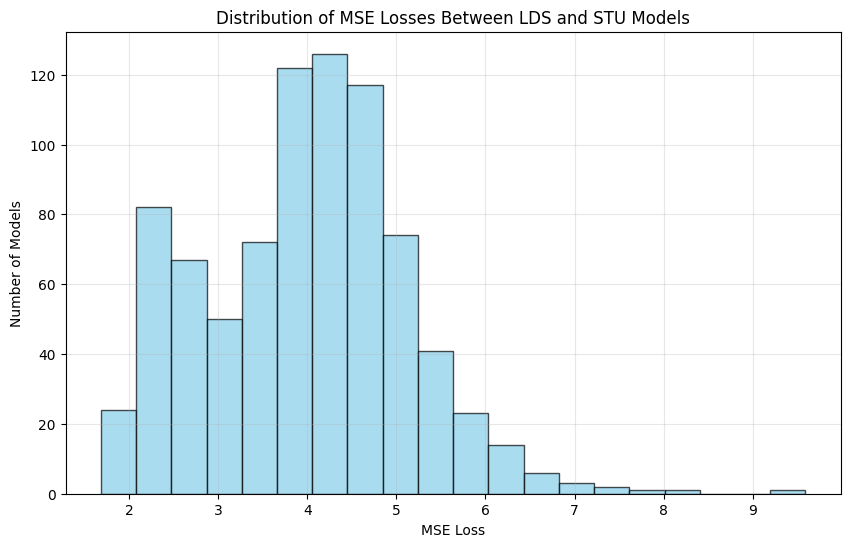

Average MSE across all models: 3.975907
Min MSE: 1.684535, Max MSE: 9.591440


In [34]:
import matplotlib.pyplot as plt
import torch.nn.functional as F
import tqdm


eval_bsz = 1 
random_inputs = torch.randn(eval_bsz, config.seq_len, d_in, device=device, dtype=torch_dtype)

mse_values = []
for model_id, lds, stu in tqdm.tqdm(loaded_pairs):
    with torch.no_grad():

        lds_outputs = []
        for i in range(eval_bsz):
            batch_input = random_inputs[i].reshape(-1, d_in)
            lds_output = lds.generate_trajectory(batch_input)
            lds_outputs.append(lds_output.reshape(1, config.seq_len, d_out))
        lds_outputs = torch.cat(lds_outputs, dim=0)
        
        # Generate STU outputs (predictions)
        stu_outputs = stu(random_inputs)
        
        # Compute MSE
        mse = F.mse_loss(stu_outputs, lds_outputs).item()
        mse_values.append(mse)
        # print(f"Model {model_id} MSE: {mse:.6f}")

# Plot histogram of MSE values
plt.figure(figsize=(10, 6))
plt.hist(mse_values, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('MSE Loss')
plt.ylabel('Number of Models')
plt.title('Distribution of MSE Losses Between LDS and STU Models')
plt.grid(alpha=0.3)
plt.show()

print(f"Average MSE across all models: {np.mean(mse_values):.6f}") #this checks out, they seem to start at ~20 and drop down
print(f"Min MSE: {np.min(mse_values):.6f}, Max MSE: {np.max(mse_values):.6f}") 


In [43]:
###CODE IS VERY SLOW, CAN BE EASILY MADE FASTER BY DOING LINEAR ALGEBRA (I.E SIMILAR TO HWO WE DID LDS FILTER/STU FILTER)
def gen_lds_impulse(lds, seq_len = config.seq_len):
    # Create impulse response for LDS
    impulse = np.zeros(seq_len)
    
    for i in range(seq_len):
        # Create input tensor with 1 at position i
        input_tensor = torch.zeros(seq_len, 1, device=lds.A.device, dtype=lds.A.dtype)
        input_tensor[i, 0] = 1.0
        
        # Forward pass through LDS model
        with torch.no_grad():
            output = lds.generate_trajectory(input_tensor)
        
        # Store the last output value
        impulse[i] = output[-1, 0].cpu().numpy()

    return np.flip(impulse)

phi_n = spectral_filters.cpu().numpy()



def gen_stu_impulse(stu, seq_len = config.seq_len):
    # Create impulse response by setting input to 1 at each position
    impulse = np.zeros(seq_len)
    
    for i in range(seq_len):
        # Create input tensor with 1 at position i
        input_tensor = torch.zeros(1, seq_len, 1, device=stu.filters.device, dtype=stu.filters.dtype)
        input_tensor[0, i, 0] = 1.0
        
        # Forward pass through STU model
        with torch.no_grad():
            output = stu(input_tensor)
        
        # Store the last output value
        impulse[i] = output[0, -1, 0].cpu().numpy()

    return np.flip(impulse)

3it [00:00,  3.29it/s]


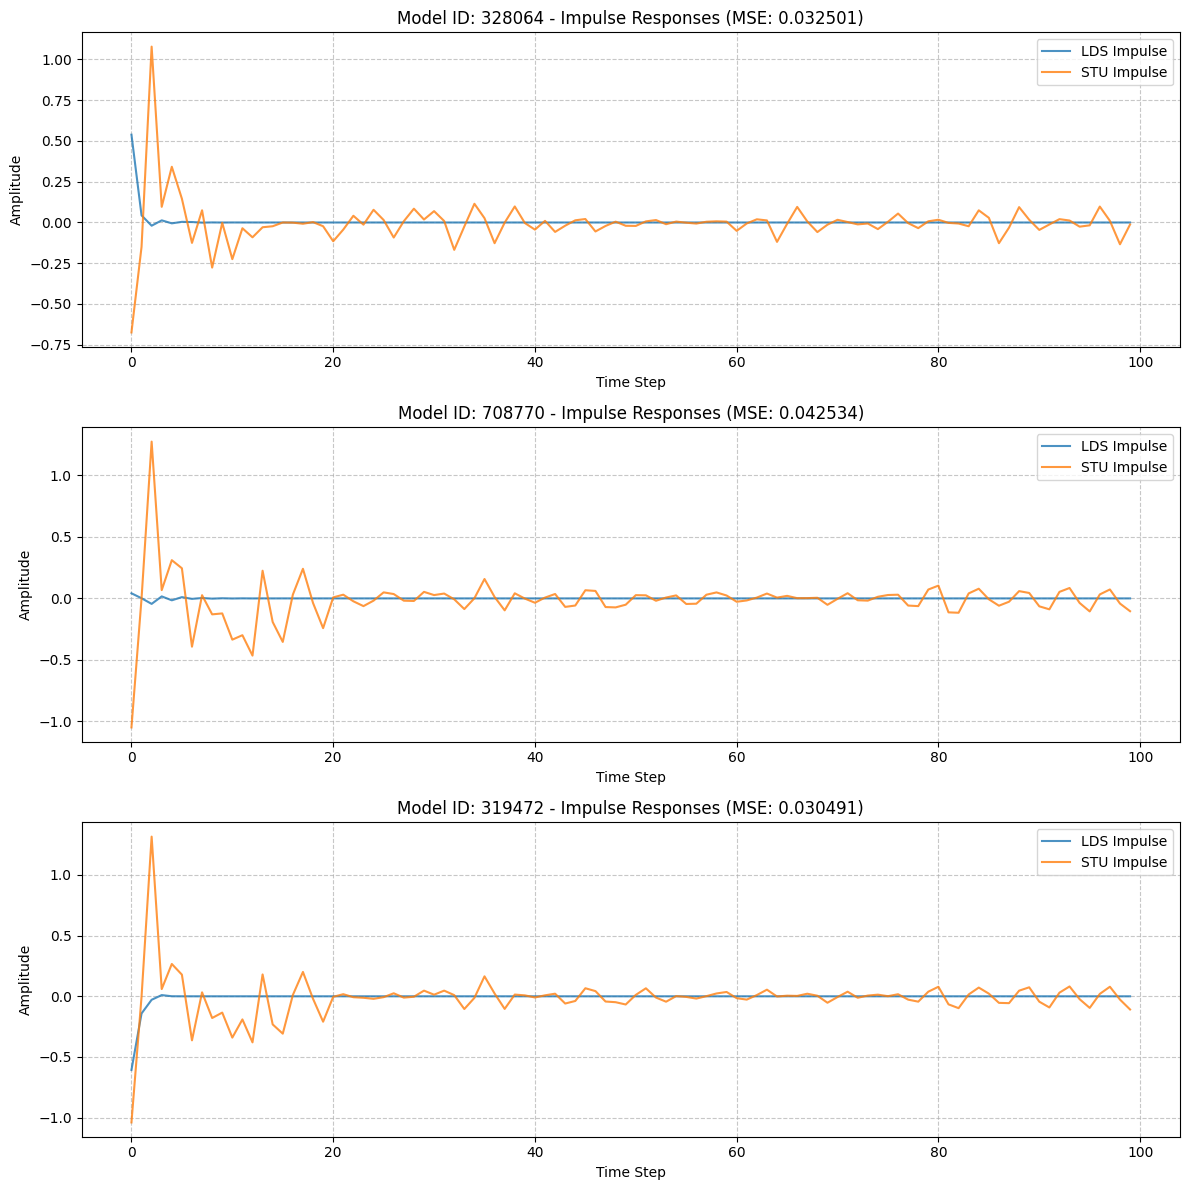

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Function to compute and display impulses for LDS and STU pairs
def plot_impulse_responses(loaded_pairs, num_to_display=3, seq_len=config.seq_len):
    # Select random pairs if we have more than requested
    if len(loaded_pairs) > num_to_display:
        selected_pairs = random.sample(loaded_pairs, num_to_display)
    else:
        selected_pairs = loaded_pairs
    
    # Create a figure with subplots
    fig, axes = plt.subplots(len(selected_pairs), 1, figsize=(12, 4*len(selected_pairs)))
    if len(selected_pairs) == 1:
        axes = [axes]  # Make axes iterable if only one subplot
    
    for i, (model_id, lds, stu) in tqdm.tqdm(enumerate(selected_pairs)):
        # Generate impulse responses
        lds_impulse = gen_lds_impulse(lds, seq_len = 100)
        stu_impulse = gen_stu_impulse(stu, seq_len = 100)
        
        # Plot both impulse responses
        ax = axes[i]
        ax.plot(lds_impulse, label='LDS Impulse', alpha=0.8)
        ax.plot(stu_impulse, label='STU Impulse', alpha=0.8)
        
        # Calculate and display MSE
        mse = np.mean((lds_impulse - stu_impulse)**2)
        
        ax.set_title(f'Model ID: {model_id} - Impulse Responses (MSE: {mse:.6f})')
        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.set_xlabel('Time Step')
        ax.set_ylabel('Amplitude')
    
    plt.tight_layout()
    plt.show()

# Compute and display impulses for random LDS, STU pairs
if loaded_pairs:
    plot_impulse_responses(loaded_pairs)
else:
    print("No model pairs loaded to display impulse responses.")


In [37]:
torch.load('./models/gen_lds_trained/877531.pt')

/var/folders/42/5cczn_jx4454n6fvhcg5qbjw0000gn/T/ipykernel_60845/521884323.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load('./models/gen_lds_trained/877531.pt

OrderedDict([('A',
              tensor([[-0.0313, -0.0977, -0.0024, -0.0334, -0.0510,  0.0379, -0.0483, -0.0470,
                       -0.0464,  0.0039],
                      [ 0.1075, -0.0271, -0.0052,  0.0187, -0.0299, -0.0067,  0.0029,  0.0181,
                       -0.0446,  0.0426],
                      [ 0.0243, -0.0294,  0.0372, -0.0131,  0.0053,  0.0366,  0.0091,  0.0958,
                        0.0326, -0.0082],
                      [-0.0323,  0.0274,  0.0465, -0.0286,  0.0300,  0.0350, -0.0157,  0.0287,
                        0.0102,  0.0157],
                      [ 0.0107,  0.0075, -0.0454,  0.0364, -0.0324, -0.0616, -0.0852, -0.0647,
                       -0.0952, -0.0077],
                      [ 0.0195, -0.0199, -0.0522,  0.0549,  0.0312,  0.0631,  0.0324, -0.0149,
                       -0.0656, -0.0409],
                      [-0.0185,  0.0193, -0.0863,  0.0002, -0.0446,  0.0241,  0.1009,  0.0254,
                       -0.0039,  0.0653],
                      